<a href="https://colab.research.google.com/github/junseok-jay/AI_lab/blob/main/week3/audio_setting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.5 MB/s eta 0:00:00


In [29]:
import io, torch, os, tarfile, tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

import torchaudio

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

/tmp/ipython-input-3656432517.py:13: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
/tmp/ipython-input-3656432517.py:14: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
/tmp/ipython-input-3656432517.py:15: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a

In [8]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


/tmp/ipython-input-3458049858.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_WAV)


In [22]:
# Checking metadata of sample audio
mySampleUrls = [
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522039.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522040.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522041.m4a",
  "/content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522042.m4a"
]

for i, path in enumerate(mySampleUrls):
  try:
    metadata = torchaudio.info(path)
    print(f"[{i}] {path}")
    print(metadata)
  except Exception as e:
    print(f"[{i}] {path} -> Error : {e}")

[0] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522039.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[1] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522040.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[2] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522041.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)
[3] /content/drive/MyDrive/Colab Notebooks/AI_lab/week3/sample_audio/095522042.m4a
AudioMetaData(sample_rate=44100, num_frames=174, num_channels=1, bits_per_sample=0, encoding=AAC)


/tmp/ipython-input-307298819.py:11: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(path)


In [24]:
waveform, sample_rate = torchaudio.load(mySampleUrls[0])

In [35]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

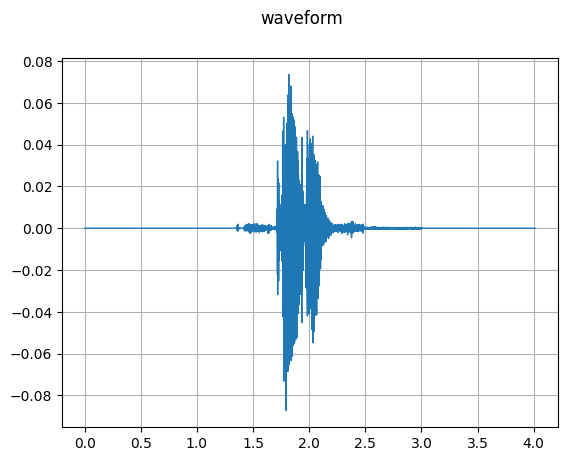

In [36]:
plot_waveform(waveform, sample_rate)

In [38]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

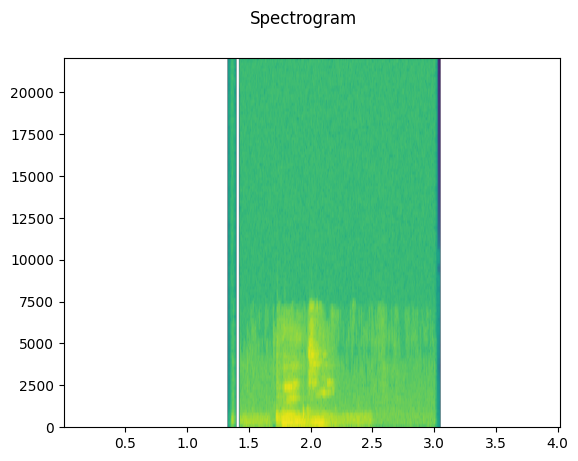

In [40]:
plot_specgram(waveform, sample_rate)

In [41]:
Audio(waveform.numpy()[0], rate=sample_rate)